In [92]:
import sys
sys.path.append('../')

In [2]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
from utils.backtest import calc_single_asset_backtest
from utils.data_loaders import load_clc_db_records
from utils.features import construct_features_batch
from utils.data_handling import merge_asset_data, split_by_date
from utils.loss_functions import return_loss, sharpe_loss, return_loss_dummy, sharpe_loss_dummy

In [4]:
config = tf.ConfigProto(device_count = {'GPU': 1 , 'CPU': 8}) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [5]:
SIGMA_TARGET = 0.15

In [6]:
RAD_DATA_PATH = '../data/clc/rad/'
FED_DATA_PATH = '../data/FEDFUNDS.csv'

In [7]:
clc = load_clc_db_records(RAD_DATA_PATH, FED_DATA_PATH)

In [8]:
clc = construct_features_batch(clc)
for asset, df in clc.items():
    df.set_index('Date', inplace=True)

../utils/features.py:52: RuntimeWarning: invalid value encountered in log
  df['Sigma_Norm'] = np.log(df['Sigma'] / df['Sigma'].rolling(181).mean())


In [50]:
assets_to_use = ['AN', 'BN', 'CC', 'CN', 'CT', 'DT', 'DX', 'EC', 'FB', 'FF', 'FN',
       'FX', 'GI', 'GS', 'JN', 'JO', 'KC', 'KW', 'LB', 'LX', 'MD', 'MW',
       'NK', 'NR', 'PA', 'SB', 'SN', 'SP', 'SS', 'TU', 'TY', 'US', 'W',
       'ZA', 'ZB', 'ZC', 'ZF', 'ZG', 'ZH', 'ZI', 'ZK', 'ZL', 'ZM', 'ZN',
       'ZO', 'ZP', 'ZR', 'ZS', 'ZT', 'ZU', 'ZW', 'ZZ']
exclude_assets = ['FF', 'EC', 'TU', 'SS']
assets_to_use = list(set(assets_to_use) - set(exclude_assets))

temp_clc = {}
for asset, df in clc.items():
    if asset in assets_to_use:
        temp_clc[asset] = df
clc = temp_clc

In [9]:
df = clc['SC']

In [10]:
df = df['1990-1-1':'2020-1-1']

In [51]:
calc_single_asset_backtest(df.Returns_Daily, df.Excess_Returns_Daily, pd.Series(1, index=df.index))

E[Return]                         0.069071
E[Excess Return]                  0.028033
Std[Return]                       0.190401
Skew[Return]                     -1.066743
Exc.Kurtosis[Return]             49.929156
Sharpe                            0.147232
Max_Drawdown                     -0.628860
Max_Drawdown_Duration (Years)    13.297619
dtype: float64

In [52]:
monthly_returns = ((1 + df.Returns_Daily).resample('M').prod() - 1).rename('Monthly_Returns')
yearly_returns = ((1 + df.Returns_Daily).rolling(252).apply(np.prod, raw=True) - 1).rename('Yearly_Returns')
vola = np.sqrt(252) * df['Sigma']
sign_data = pd.DataFrame([monthly_returns, yearly_returns, vola]).T
sign_data.dropna(inplace=True)
sign_data['SIGN'] = 2 * (sign_data['Yearly_Returns'] >= 0) - 1
sign_data['Next_Monthly_Returns'] = sign_data['Monthly_Returns'].shift(-1)
sign_data['Strategy_Weight'] = sign_data['SIGN'] * SIGMA_TARGET / sign_data['Sigma']
sign_data['Performance'] = sign_data['Strategy_Weight'] * sign_data['Next_Monthly_Returns']

In [23]:
calc_single_asset_backtest(df.Returns_Daily, df.Excess_Returns_Daily, sign_data.Strategy_Weight)

E[Return]                        0.098382
E[Excess Return]                 0.075886
Std[Return]                      0.163695
Skew[Return]                    -0.621192
Exc.Kurtosis[Return]             5.796106
Sharpe                           0.463580
Max_Drawdown                    -0.298306
Max_Drawdown_Duration (Years)    3.507937
dtype: float64

In [53]:
long_backtest_results = {}
for asset, df in clc.items():
    df = df['1990-1-1':'2020-1-1']
    long_backtest_results[asset] = calc_single_asset_backtest(df.Returns_Daily, df.Excess_Returns_Daily, pd.Series(1, index=df.index))

In [54]:
short_backtest_results = {}
for asset, df in clc.items():
    df = df['1990-1-1':'2020-1-1']
    short_backtest_results[asset] = calc_single_asset_backtest(df.Returns_Daily, df.Excess_Returns_Daily, pd.Series(-1, index=df.index))

In [85]:
backtest_results = {}
for asset, df in clc.items():
    df = df['1990-1-1':'2020-1-1']
    monthly_returns = ((1 + df.Returns_Daily).resample('M').prod() - 1).rename('Monthly_Returns')
    yearly_returns = ((1 + df.Returns_Daily).rolling(252).apply(np.prod, raw=True) - 1).rename('Yearly_Returns')
    vola = np.sqrt(252) * df['Sigma']
    sign_data = pd.DataFrame([monthly_returns, yearly_returns, vola]).T
    sign_data.dropna(inplace=True)
    sign_data['SIGN'] = 2 * (sign_data['Yearly_Returns'] >= 0) - 1
    sign_data['Next_Monthly_Returns'] = sign_data['Monthly_Returns'].shift(-1)
    sign_data['Strategy_Weight'] = sign_data['SIGN'] * SIGMA_TARGET / sign_data['Sigma']
    sign_data['Performance'] = sign_data['Strategy_Weight'] * sign_data['Next_Monthly_Returns']
    backtest_results[asset] = calc_single_asset_backtest(df.Returns_Daily, df.Excess_Returns_Daily, sign_data.Strategy_Weight)

In [86]:
sign_df = pd.DataFrame(backtest_results)
sign_df

,ZM,US,ZK,ZN,TY,FB,PA,CN,FN,ZL,...,JO,ZZ,SN,ZI,DX,ZG,LB,MW,NK,SP
E[Return],-0.029446,0.032393,0.005625,0.001491,0.058048,0.081569,0.089354,0.013919,0.009755,0.019316,...,-0.033105,-0.011515,-0.006027,-0.014374,0.010574,0.058420,0.055889,0.032814,0.017711,0.084599
E[Excess Return],-0.030420,0.007723,0.003067,0.004292,0.027579,0.044254,0.086318,0.012458,0.010767,0.025193,...,-0.030839,-0.015059,0.006055,-0.008950,0.008231,0.076968,0.058767,0.035252,0.016396,0.060637
Std[Return],0.160812,0.156675,0.159206,0.163685,0.156898,0.157434,0.163859,0.159096,0.155955,0.156953,...,0.165644,0.157110,0.168953,0.161588,0.157429,0.162257,0.155156,0.160432,0.160674,0.162154
Skew[Return],-0.189931,-0.174434,-0.170542,-0.047738,-0.102333,-0.071406,0.158683,-0.209126,-0.120720,-0.215206,...,-1.503853,0.020845,-4.372202,-0.278236,-0.133585,-0.658437,-0.053313,-0.145806,-0.376603,-0.567701
Exc.Kurtosis[Return],3.359337,1.112800,3.001134,4.362220,1.585089,2.104369,6.772640,2.199634,1.408356,1.694972,...,42.786704,0.755653,137.648129,4.384731,1.325018,12.716904,-0.269297,1.551736,4.032220,5.493320
Sharpe,-0.189163,0.049294,0.019267,0.026224,0.175774,0.281098,0.526779,0.078304,0.069042,0.160514,...,-0.186173,-0.095848,0.035836,-0.055390,0.052284,0.474357,0.378760,0.219734,0.102045,0.373949
Max_Drawdown,-0.812272,-0.521493,-0.570428,-0.646750,-0.527391,-0.453876,-0.474444,-0.477487,-0.660232,-0.488473,...,-0.748043,-0.711706,-0.660577,-0.595834,-0.655433,-0.441676,-0.431114,-0.567040,-0.550260,-0.298344
Max_Drawdown_Duration (Years),10.130952,8.192000,14.980159,24.345238,8.192000,5.692000,7.198413,8.604743,11.706349,6.730159,...,28.365079,21.023810,15.023715,26.769841,11.643411,6.222222,9.234127,11.857143,16.142857,3.507937


In [87]:
long_df = pd.DataFrame(long_backtest_results)
short_df = pd.DataFrame(short_backtest_results)
long_df

,ZM,US,ZK,ZN,TY,FB,PA,CN,FN,ZL,...,JO,ZZ,SN,ZI,DX,ZG,LB,MW,NK,SP
E[Return],0.072242,0.045132,0.040869,-0.203654,0.036260,0.026334,0.110789,-0.000148,-0.003557,-0.030739,...,-0.050507,-0.032760,0.001569,0.005229,-0.008260,0.015341,-0.076141,0.013909,-0.004468,0.063597
E[Excess Return],0.042073,0.015636,0.011645,-0.224594,0.007015,-0.002632,0.079055,-0.028384,-0.031593,-0.058017,...,-0.077172,-0.059984,-0.026720,-0.023003,-0.036647,-0.013171,-0.102166,-0.014617,-0.030493,0.033678
Std[Return],0.243238,0.096284,0.255762,0.477947,0.059192,0.039152,0.312673,0.077417,0.100959,0.220149,...,0.317976,0.245550,0.114910,0.280290,0.084483,0.159636,0.285074,0.226993,0.238875,0.178116
Skew[Return],0.075466,-0.151753,-0.019223,0.226414,-0.066209,-0.115307,-0.030883,-0.023878,0.026320,0.235208,...,0.820079,0.027535,1.657899,-0.515845,-0.020956,-0.077373,0.151814,0.231717,0.027084,0.045155
Exc.Kurtosis[Return],2.305057,1.588973,4.244446,2.791520,3.008259,3.064948,5.052180,5.873745,1.946064,2.156607,...,12.542530,1.247414,44.760862,6.821933,1.836374,8.051008,-0.079560,2.458354,5.427603,11.292540
Sharpe,0.172969,0.162398,0.045530,-0.469914,0.118512,-0.067217,0.252837,-0.366638,-0.312926,-0.263534,...,-0.242697,-0.244285,-0.232528,-0.082070,-0.433778,-0.082508,-0.358385,-0.064394,-0.127652,0.189081
Max_Drawdown,-0.452612,-0.193498,-0.685807,-0.999268,-0.140358,-0.097641,-0.883074,-0.349617,-0.492001,-0.782398,...,-0.900919,-0.828266,-0.507492,-0.743369,-0.448182,-0.628368,-0.981892,-0.739010,-0.794180,-0.628860
Max_Drawdown_Duration (Years),6.789683,3.071146,8.876984,25.809524,3.083004,3.644269,16.861111,12.972332,24.654762,17.634921,...,28.007937,22.980159,16.177866,16.115079,18.244186,17.801587,26.777778,11.857143,29.071429,13.297619


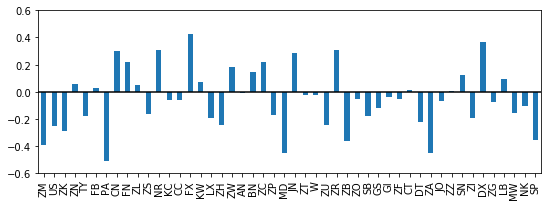

In [88]:
plt.figure(figsize=(9, 3))
short_df.loc['Sharpe'].plot('bar')
plt.ylim(-0.6, 0.6)
plt.hlines(0, -10, 90)

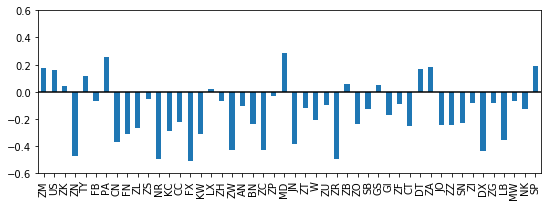

In [89]:
plt.figure(figsize=(9, 3))
long_df.loc['Sharpe'].plot('bar')
plt.ylim(-0.6, 0.6)
plt.hlines(0, -10, 90)

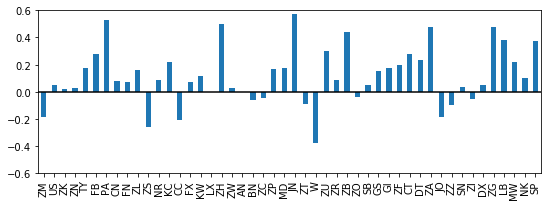

In [91]:
plt.figure(figsize=(9, 3))
sign_df.loc['Sharpe'].plot('bar')
plt.ylim(-0.6, 0.6)
plt.hlines(0, -10, 90)

In [ ]:
long_df.loc['Std[Return]'] > sign_df.loc['Std[Return]']

In [48]:
short_df.loc['Sharpe'] < sign_df.loc['Sharpe']

ZM     True
FF    False
US     True
ZK     True
ZN    False
TY     True
FB     True
PA     True
CN    False
FN    False
ZL     True
ZS    False
NR    False
KC     True
CC    False
FX    False
KW     True
LX     True
EC    False
ZH     True
ZW    False
AN     True
BN    False
ZC    False
ZP     True
MD     True
JN     True
ZT    False
W     False
ZU     True
ZR    False
ZB     True
ZO     True
SB     True
GS     True
GI     True
ZF     True
TU    False
CT     True
DT     True
SS    False
ZA     True
JO    False
ZZ    False
SN    False
ZI     True
DX    False
ZG     True
LB     True
MW     True
NK     True
SP     True
Name: Sharpe, dtype: bool

In [49]:
long_df.loc['Sharpe'] < -0.6  

ZM    False
FF     True
US    False
ZK    False
ZN    False
TY    False
FB    False
PA    False
CN    False
FN    False
ZL    False
ZS    False
NR    False
KC    False
CC    False
FX    False
KW    False
LX    False
EC     True
ZH    False
ZW    False
AN    False
BN    False
ZC    False
ZP    False
MD    False
JN    False
ZT    False
W     False
ZU    False
ZR    False
ZB    False
ZO    False
SB    False
GS    False
GI    False
ZF    False
TU     True
CT    False
DT    False
SS     True
ZA    False
JO    False
ZZ    False
SN    False
ZI    False
DX    False
ZG    False
LB    False
MW    False
NK    False
SP    False
Name: Sharpe, dtype: bool